In [173]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
!pip install ipywidgets


In [83]:
ImT1_L = cv2.imread('./image_0/0.jpg', 0)    #0 flag returns a grayscale image
ImT1_R = cv2.imread('./image_1/0.jpg', 0)

ImT2_L = cv2.imread('./image_0/1.jpg', 0)
ImT2_R = cv2.imread('./image_1/1.jpg', 0)

calibFile = open('./calib.txt', 'r').readlines()
P1Vals = calibFile[0].split()
Proj1 = np.zeros((3,4))
for row in range(3):
    for column in range(4):
        Proj1[row, column] = float(P1Vals[row*4 + column + 1])

P2Vals = calibFile[1].split()
Proj2 = np.zeros((3,4))
for row in range(3):
    for column in range(4):
        Proj2[row, column] = float(P2Vals[row*4 + column + 1])

# cv2.imshow('ImT1_L', ImT1_L)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

block = 15

#emperical values from P1, P2 as suggested in Ocv documentation
P1 = 0 #block * block * 8
P2 = 0 #block * block * 32

disparityEngine = cv2.StereoSGBM_create(minDisparity=0,numDisparities=16, blockSize=block, P1=P1, P2=P2)
ImT1_disparity = disparityEngine.compute(ImT1_L, ImT1_R).astype(np.float32)
#cv2.imwrite('disparity.png', ImT1_disparity)
ImT1_disparityA = np.divide(ImT1_disparity, 16.0)

ImT2_disparity = disparityEngine.compute(ImT2_L, ImT2_R).astype(np.float32)
ImT2_disparityA = np.divide(ImT2_disparity, 16.0)

In [84]:
TILE_H = 10
TILE_W = 20
fastFeatureEngine = cv2.FastFeatureDetector_create()


# keypoints = fastFeatureEngine.detect(ImT1_L)
# ftDebug = ImT1_L
# ftDebug = cv2.drawKeypoints(ImT1_L, keypoints, ftDebug, color=(255,0,0))
# cv2.imwrite('ftDebug.png', ftDebug)

#20x10 (wxh) tiles for extracting less features from images 
H,W = ImT1_L.shape
kp = []
idx = 0
for y in range(0, H, TILE_H):
    for x in range(0, W, TILE_W):
        imPatch = ImT1_L[y:y+TILE_H, x:x+TILE_W]
        keypoints = fastFeatureEngine.detect(imPatch)
        for pt in keypoints:
            pt.pt = (pt.pt[0] + x, pt.pt[1] + y)
        
        if (len(keypoints) > 10):
            keypoints = sorted(keypoints, key=lambda x: -x.response)
            for kpt in keypoints[0:10]:
                kp.append(kpt)
        else:
            for kpt in keypoints:
                kp.append(kpt)

ftDebug = ImT1_L
ftDebug = cv2.drawKeypoints(ImT1_L, kp, ftDebug, color=(255,0,0))
cv2.imwrite('ftDebug.png', ftDebug)

True

In [90]:
# pack keypoint 2-d coords into numpy array
trackPoints1 = np.zeros((len(kp),1,2), dtype=np.float32)
for i,kpt in enumerate(kp):
    trackPoints1[i,:,0] = kpt.pt[0]
    trackPoints1[i,:,1] = kpt.pt[1]

# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15,15),
                  maxLevel = 3,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 50, 0.03))

trackPoints2, st, err = cv2.calcOpticalFlowPyrLK(ImT1_L, ImT2_L, trackPoints1, None, flags=cv2.MOTION_AFFINE, **lk_params)

In [ ]:
# pack keypoint 2-d coords into numpy array
# separate points that were tracked successfully
ptTrackable = np.where(st == 1, 1,0).astype(bool)
trackPoints1_KLT = trackPoints1[ptTrackable, ...]
trackPoints2_KLT_t = trackPoints2[ptTrackable, ...]
trackPoints2_KLT = np.around(trackPoints2_KLT_t)

# among tracked points take points within error measure
error = 4
errTrackablePoints = err[ptTrackable, ...]
errThresholdedPoints = np.where(errTrackablePoints < error, 1, 0).astype(bool)
trackPoints1_KLT = trackPoints1_KLT[errThresholdedPoints, ...]
trackPoints2_KLT = trackPoints2_KLT[errThresholdedPoints, ...]

# convert keypoint lists to numpy arrays
points1 = []
points2 = []
for i,kpt in enumerate(kp):
    if i < len(ptTrackable) and i < len(errTrackablePoints) and ptTrackable[i] and errTrackablePoints[i]:
        points1.append([kpt.pt[0], kpt.pt[1]])
        points2.append([trackPoints2_KLT_t[i, 0], trackPoints2_KLT_t[i, 1]])


# convert to numpy arrays
points1 = np.array(points1, dtype=np.float32)
points2 = np.array(points2, dtype=np.float32)



from here beigin my code

In [91]:
# compute fundamental matrix using SVD
A = np.zeros((len(points1), 9))
for i in range(len(points1)):
    A[i][0] = points2[i][0] * points1[i][0]
    A[i][1] = points2[i][0] * points1[i][1]
    A[i][2] = points2[i][0]
    A[i][3] = points2[i][1] * points1[i][0]
    A[i][4] = points2[i][1] * points1[i][1]
    A[i][5] = points2[i][1]
    A[i][6] = points1[i][0]
    A[i][7] = points1[i][1]
    A[i][8] = 1

u, s, v = np.linalg.svd(A)
F = v[-1].reshape(3, 3)

u, s, v = np.linalg.svd(F)
s[2] = 0
F = np.dot(np.dot(u, np.diag(s)), v)

F = F / F[2, 2]


print("Fundamental matrix:\n", F)


Fundamental matrix:
 [[ 1.25314032e-06  2.83036938e-06 -1.15636240e-03]
 [ 2.02661066e-06  5.19078225e-06 -1.79994023e-03]
 [-1.12937801e-03 -2.91944828e-03  1.00000000e+00]]


In [92]:
import numpy as np

# Load projection matrices from calib.txt
calib_file = 'calib.txt'
with open(calib_file, 'r') as f:
    lines = f.readlines()

P0 = np.array([float(x) for x in lines[0].strip().split(' ')[1:]]).reshape(3, 4)
P1 = np.array([float(x) for x in lines[1].strip().split(' ')[1:]]).reshape(3, 4)
P2 = np.array([float(x) for x in lines[2].strip().split(' ')[1:]]).reshape(3, 4)
P3 = np.array([float(x) for x in lines[3].strip().split(' ')[1:]]).reshape(3, 4)

# Compute camera intrinsics 
K = P0[:3, :3]
fx = K[0, 0]
fy = K[1, 1]
cx = K[0, 2]
cy = K[1, 2]

# Compute baseline
baseline = -P1[0, 3] / fx
print('Focal length: ({}, {})'.format(fx, fy))
print('Image center: ({}, {})'.format(cx, cy))
print('Baseline: {}'.format(baseline))


Focal length: (718.856, 718.856)
Image center: (607.1928, 185.2157)
Baseline: 0.5371657188644179


In [111]:
# calculate epilines
lines2 = cv2.computeCorrespondEpilines(points1.reshape(-1,1,2), 1, F)
lines2 = lines2.reshape(-1,3)
lines1 = cv2.computeCorrespondEpilines(points2.reshape(-1,1,2), 2, F)
lines1 = lines1.reshape(-1,3)

# find closest points on epilines
dist = []
for i in range(len(points1)):
    p1 = points1[i]
    p2 = points2[i]
    l1 = lines1[i]
    l2 = lines2[i]
    a = np.array([[l1[0], l1[1]], [l2[0], l2[1]]])
    b = np.array([-l1[2], -l2[2]])
    p = np.linalg.solve(a, b)
    dist.append(abs(np.dot(p - p1, [l1[1], -l1[0]])))
dist = np.array(dist)

dist

array([ 758.24896,  764.677  ,  753.9035 , ..., 4241.442  , 4641.043  ,
       4635.4565 ], dtype=float32)

In [113]:
# calculate disparity
disparity = np.zeros((len(points1),))
disparity[dist < 5] = np.sqrt(np.sum((points1[dist < 5] - points2[dist < 5])**2, axis=1))

In [154]:
# calculate depth
focalLength = 718.856
baseline = 0.5371657188644179

# compute disparity from F matrix
disparity = np.zeros((len(points1),))
for i in range(len(points1)):
    x1, y1 = points1[i]
    x2, y2 = points2[i]
    epipolarLine = np.dot(F, [x1, y1, 1])
    a, b, c = epipolarLine
    d = np.abs(a*x2 + b*y2 + c) / np.sqrt(a*a + b*b)
    disparity[i] = d

# compute depth
depth = (focalLength * baseline) / (disparity + 1e-10)


array([0.86846906, 0.87639465, 0.87637367, ..., 1.34276747, 1.44728493,
       1.48329078])

In [137]:
points1

array([[ 12.,   3.],
       [  6.,   4.],
       [ 16.,   4.],
       ...,
       [752., 336.],
       [765., 333.],
       [772., 334.]], dtype=float32)

In [98]:
points2

array([[  24.780704,   10.776004],
       [  33.209316,   10.093533],
       [  29.699678,   12.240453],
       ...,
       [1033.8129  ,  368.29593 ],
       [1014.9491  ,  352.96655 ],
       [1006.43506 ,  348.8216  ]], dtype=float32)

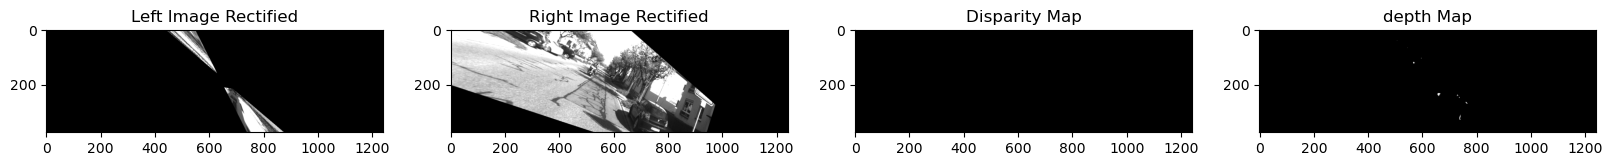

In [185]:

import cv2
import numpy as np
import matplotlib.pyplot as plt

def rectify_and_compute_disparity(img1, img2, F, points1, points2):
    h, w = img1.shape

    # Compute the rectification transformations
    _, H1, H2 = cv2.stereoRectifyUncalibrated(np.float32(points1), np.float32(points2), F, (w, h))

    img1_rectified = cv2.warpPerspective(img1, H1, (w, h))
    img2_rectified = cv2.warpPerspective(img2, H2, (w, h))

    stereo = cv2.StereoBM_create(numDisparities=64, blockSize=15)
    disparity_map = stereo.compute(img1_rectified, img2_rectified)

    return img1_rectified, img2_rectified, disparity_map



def show_images(left_rectified, right_rectified, disparity_norm,depth_map_norm):
    _, ax = plt.subplots(1, 4, figsize=(20, 20))
    ax[0].imshow(left_rectified, cmap='gray')
    ax[0].set_title('Left Image Rectified')
    ax[1].imshow(right_rectified, cmap='gray')
    ax[1].set_title('Right Image Rectified')
    ax[2].imshow(disparity_norm, cmap='gray')
    ax[2].set_title('Disparity Map')
    ax[3].imshow(depth_map_norm, cmap='gray')
    ax[3].set_title('depth Map')
    plt.show()

def compute_depth_map(disparity_map, focal_length, baseline):
    depth_map = (focal_length * baseline) / (disparity_map + 1e-6)
    return depth_map

def enhance_contrast(image, alpha=1.5, beta=50):
    new_image = np.zeros(image.shape, dtype=np.float32)
    new_image = image * alpha + beta
    new_image[new_image > 255] = 255
    new_image[new_image < 0] = 0
    return new_image.astype(np.uint8)




def main():
    F = np.array([[1.25314032e-06, 2.83036938e-06, -1.15636240e-03],
                  [2.02661066e-06, 5.19078225e-06, -1.79994023e-03],
                  [-1.12937801e-03, -2.91944828e-03, 1.00000000e+00]])

    focal_length = 718.856
    baseline = 0.5371657188644179

    img1 = ImT1_L
    img2 = ImT1_R

    img1_rectified, img2_rectified, disparity_map = rectify_and_compute_disparity(img1, img2, F, points1, points2)
    img1_rectified = enhance_contrast(img1_rectified)
    img2_rectified = enhance_contrast(img2_rectified)

    cv2.imwrite('left_image_rectified.png', img1_rectified)
    cv2.imwrite('right_image_rectified.png', img2_rectified)
    
    disparity_map_norm = cv2.normalize(disparity_map, None, 0, 255, cv2.NORM_INF, dtype=cv2.CV_8U)
    cv2.imwrite('disparity_map.png', disparity_map_norm)

    depth_map = compute_depth_map(disparity_map, focal_length, baseline)
    depth_map_norm = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    cv2.imwrite('depth_map.png', depth_map_norm)

    show_images(img1_rectified, img2_rectified, disparity_map_norm,depth_map_norm)

if __name__ == '__main__':
    main()


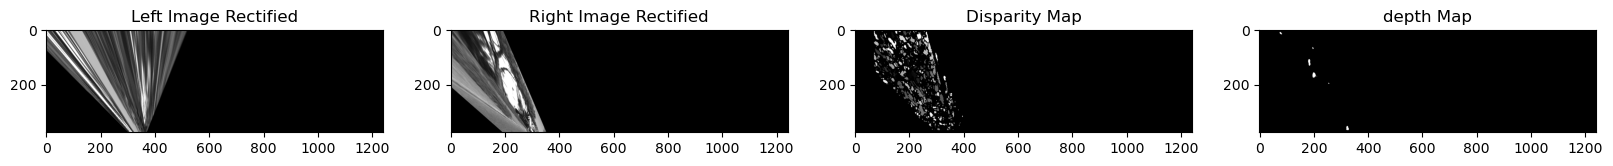

In [191]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def rectify_and_compute_disparity(img1, img2, F, points1, points2):
    h, w = img1.shape

    # Compute the rectification transformations
    _, H1, H2 = cv2.stereoRectifyUncalibrated(np.float32(points1), np.float32(points2), F, (w, h))

    img1_rectified = cv2.warpPerspective(img1, H1, (w, h))
    img2_rectified = cv2.warpPerspective(img2, H2, (w, h))

    stereo = cv2.StereoBM_create(numDisparities=64, blockSize=15)
    disparity_map = stereo.compute(img1_rectified, img2_rectified)

    return img1_rectified, img2_rectified, disparity_map



def show_images(left_rectified, right_rectified, disparity_norm,depth_map_norm):
    _, ax = plt.subplots(1, 4, figsize=(20, 20))
    ax[0].imshow(left_rectified, cmap='gray')
    ax[0].set_title('Left Image Rectified')
    ax[1].imshow(right_rectified, cmap='gray')
    ax[1].set_title('Right Image Rectified')
    ax[2].imshow(disparity_norm, cmap='gray')
    ax[2].set_title('Disparity Map')
    ax[3].imshow(depth_map_norm, cmap='gray')
    ax[3].set_title('depth Map')
    plt.show()

def compute_depth_map(disparity_map, focal_length, baseline):
    depth_map = (focal_length * baseline) / (disparity_map + 1e-6)
    return depth_map

def enhance_contrast(image, alpha=1.5, beta=50):
    new_image = np.zeros(image.shape, dtype=np.float32)
    new_image = image * alpha + beta
    new_image[new_image > 255] = 255
    new_image[new_image < 0] = 0
    return new_image.astype(np.uint8)


def main():
    F = np.array([[1.25314032e-06, 2.83036938e-06, -1.15636240e-03],
                  [2.02661066e-06, 5.19078225e-06, -1.79994023e-03],
                  [-1.12937801e-03, -2.91944828e-03, 1.00000000e+00]])

    focal_length = 718.856
    baseline = 0.5371657188644179
    
    ImT1_L = cv2.imread('./image_0/0.jpg', 0)
    ImT1_R = cv2.imread('./image_1/0.jpg', 0)

    img1 = ImT1_L
    img2 = ImT1_R

    # Increase the number of SIFT keypoint matches
    sift = cv2.SIFT_create(nfeatures=5000)
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append(m)

    points1 = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    points2 = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

    # Compute rectification transformations using F matrix
    _, H1, H2 = cv2.stereoRectifyUncalibrated(np.float32(points1), np.float32(points2), F, img1.shape)

    img1_rectified = cv2.warpPerspective(img1, H1, (img1.shape[1], img1.shape[0]))
    img2_rectified = cv2.warpPerspective(img2, H2, (img2.shape[1], img2.shape[0]))

    stereo = cv2.StereoBM_create(numDisparities=64, blockSize=15)
    disparity_map = stereo.compute(img1_rectified, img2_rectified)
    img1 = ImT1_L
    img2 = ImT1_R

    cv2.imwrite('left_image_rectified.png', img1_rectified)
    cv2.imwrite('right_image_rectified.png', img2_rectified)
    
    disparity_map_norm = cv2.normalize(disparity_map, None, 0, 255, cv2.NORM_INF, dtype=cv2.CV_8U)
    cv2.imwrite('disparity_map.png', disparity_map_norm)

    depth_map = compute_depth_map(disparity_map, focal_length, baseline)
    depth_map_norm = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    cv2.imwrite('depth_map.png', depth_map_norm)
    
    show_images(img1_rectified, img2_rectified, disparity_map, depth_map_norm)

if __name__ == '__main__':
    main()


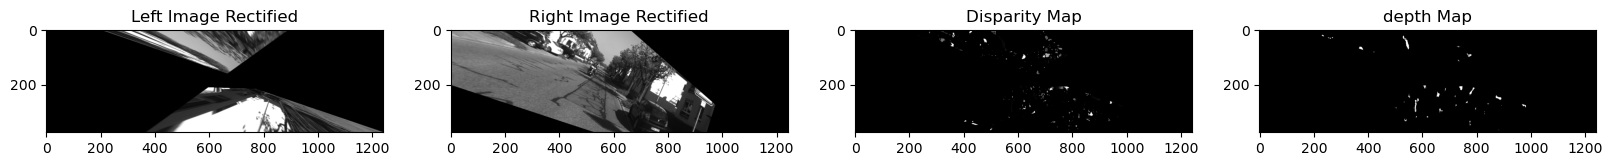

In [201]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ... (Keep the previous functions)

def rectify_images(img1, img2, points1, points2, F):
    h, w = img1.shape

    # Use the fundamental matrix to compute rectification homographies
    _, H1, H2 = cv2.stereoRectifyUncalibrated(points1, points2, F, (w, h))

    # Apply rectification homographies to the images
    img1_rectified = cv2.warpPerspective(img1, H1, (w, h))
    img2_rectified = cv2.warpPerspective(img2, H2, (w, h))

    return img1_rectified, img2_rectified




def show_images(left_rectified, right_rectified, disparity_norm,depth_map_norm):
    _, ax = plt.subplots(1, 4, figsize=(20, 20))
    ax[0].imshow(left_rectified, cmap='gray')
    ax[0].set_title('Left Image Rectified')
    ax[1].imshow(right_rectified, cmap='gray')
    ax[1].set_title('Right Image Rectified')
    ax[2].imshow(disparity_norm, cmap='gray')
    ax[2].set_title('Disparity Map')
    ax[3].imshow(depth_map_norm, cmap='gray')
    ax[3].set_title('depth Map')
    plt.show()

def compute_depth_map(disparity_map, focal_length, baseline):
    depth_map = (focal_length * baseline) / (disparity_map + 1e-6)
    return depth_map

def enhance_contrast(image, alpha=1.5, beta=50):
    new_image = np.zeros(image.shape, dtype=np.float32)
    new_image = image * alpha + beta
    new_image[new_image > 255] = 255
    new_image[new_image < 0] = 0
    return new_image.astype(np.uint8)


def main():
    F = np.array([[1.25314032e-06, 2.83036938e-06, -1.15636240e-03],
                  [2.02661066e-06, 5.19078225e-06, -1.79994023e-03],
                  [-1.12937801e-03, -2.91944828e-03, 1.00000000e+00]])

    focal_length = 718.856
    baseline = 0.5371657188644179
    
    img1 = cv2.imread('./image_0/0.jpg', 0)
    img2 = cv2.imread('./image_1/0.jpg', 0)

    # Compute keypoints and matches
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append(m)

    points1 = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    points2 = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

    img1_rectified, img2_rectified = rectify_images(img1, img2, points1, points2, F)

    stereo = cv2.StereoBM_create(numDisparities=32, blockSize=15)
    disparity_map = stereo.compute(img1_rectified, img2_rectified)

    depth_map = compute_depth_map(disparity_map, focal_length, baseline)
    depth_map_norm = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    show_images(img1_rectified, img2_rectified, disparity_map, depth_map_norm)

if __name__ == '__main__':
    main()

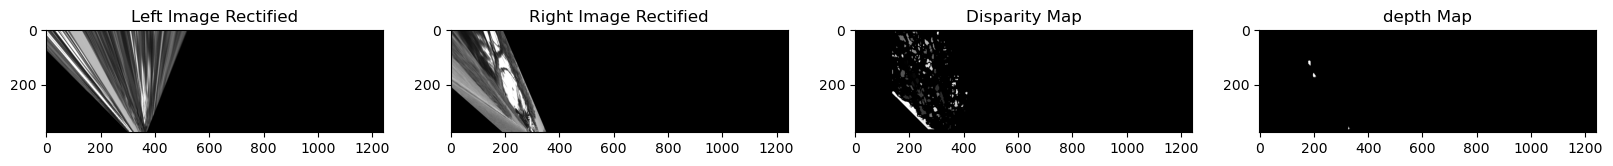

In [211]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def rectify_and_compute_disparity(img1, img2, F, points1, points2):
    h, w = img1.shape

    # Compute the rectification transformations
    _, H1, H2 = cv2.stereoRectifyUncalibrated(np.float32(points1), np.float32(points2), F, (w, h))

    img1_rectified = cv2.warpPerspective(img1, H1, (w, h))
    img2_rectified = cv2.warpPerspective(img2, H2, (w, h))

    stereo = cv2.StereoBM_create(numDisparities=64, blockSize=15)
    disparity_map = stereo.compute(img1_rectified, img2_rectified)

    return img1_rectified, img2_rectified, disparity_map



def show_images(left_rectified, right_rectified, disparity_norm,depth_map_norm):
    _, ax = plt.subplots(1, 4, figsize=(20, 20))
    ax[0].imshow(left_rectified, cmap='gray')
    ax[0].set_title('Left Image Rectified')
    ax[1].imshow(right_rectified, cmap='gray')
    ax[1].set_title('Right Image Rectified')
    ax[2].imshow(disparity_norm, cmap='gray')
    ax[2].set_title('Disparity Map')
    ax[3].imshow(depth_map_norm, cmap='gray')
    ax[3].set_title('depth Map')
    plt.show()

def compute_depth_map(disparity_map, focal_length, baseline):
    depth_map = (focal_length * baseline) / (disparity_map + 1e-6)
    return depth_map

def enhance_contrast(image, alpha=1.5, beta=50):
    new_image = np.zeros(image.shape, dtype=np.float32)
    new_image = image * alpha + beta
    new_image[new_image > 255] = 255
    new_image[new_image < 0] = 0
    return new_image.astype(np.uint8)


def main():
    F = np.array([[1.25314032e-06, 2.83036938e-06, -1.15636240e-03],
                  [2.02661066e-06, 5.19078225e-06, -1.79994023e-03],
                  [-1.12937801e-03, -2.91944828e-03, 1.00000000e+00]])

    focal_length = 718.856
    baseline = 0.5371657188644179
    
    ImT1_L = cv2.imread('./image_0/0.jpg', 0)
    ImT1_R = cv2.imread('./image_1/0.jpg', 0)

    img1 = ImT1_L
    img2 = ImT1_R

    # Increase the number of SIFT keypoint matches
    sift = cv2.SIFT_create(nfeatures=5000)
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append(m)

    points1 = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    points2 = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

    # Compute rectification transformations using F matrix
    _, H1, H2 = cv2.stereoRectifyUncalibrated(np.float32(points1), np.float32(points2), F, img1.shape)

    img1_rectified = cv2.warpPerspective(img1, H1, (img1.shape[1], img1.shape[0]))
    img2_rectified = cv2.warpPerspective(img2, H2, (img2.shape[1], img2.shape[0]))

    stereo = cv2.StereoBM_create(numDisparities=128, blockSize=21)
    disparity_map = stereo.compute(img1_rectified, img2_rectified)

    depth_map = compute_depth_map(disparity_map, focal_length, baseline)
    depth_map_norm = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    show_images(img1_rectified, img2_rectified, disparity_map, depth_map_norm)

if __name__ == '__main__':
    main()


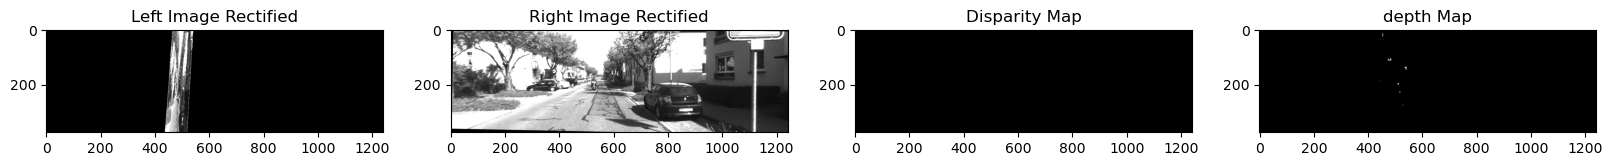

In [186]:

import cv2
import numpy as np
import matplotlib.pyplot as plt

def rectify_and_compute_disparity(img1, img2, points1, points2):
    h, w = img1.shape
    
    # Recompute the fundamental matrix using 8-point algorithm
    F, _ = cv2.findFundamentalMat(points1, points2, cv2.FM_8POINT)
    
    # Compute the rectification transformations
    _, H1, H2 = cv2.stereoRectifyUncalibrated(np.float32(points1), np.float32(points2), F, (w, h))

    img1_rectified = cv2.warpPerspective(img1, H1, (w, h))
    img2_rectified = cv2.warpPerspective(img2, H2, (w, h))

    stereo = cv2.StereoBM_create(numDisparities=64, blockSize=15)
    disparity_map = stereo.compute(img1_rectified, img2_rectified)

    return img1_rectified, img2_rectified, disparity_map


def show_images(left_rectified, right_rectified, disparity_norm,depth_map_norm):
    _, ax = plt.subplots(1, 4, figsize=(20, 20))
    ax[0].imshow(left_rectified, cmap='gray')
    ax[0].set_title('Left Image Rectified')
    ax[1].imshow(right_rectified, cmap='gray')
    ax[1].set_title('Right Image Rectified')
    ax[2].imshow(disparity_norm, cmap='gray')
    ax[2].set_title('Disparity Map')
    ax[3].imshow(depth_map_norm, cmap='gray')
    ax[3].set_title('depth Map')
    plt.show()

def compute_depth_map(disparity_map, focal_length, baseline):
    depth_map = (focal_length * baseline) / (disparity_map + 1e-6)
    return depth_map

def enhance_contrast(image, alpha=1.5, beta=50):
    new_image = np.zeros(image.shape, dtype=np.float32)
    new_image = image * alpha + beta
    new_image[new_image > 255] = 255
    new_image[new_image < 0] = 0
    return new_image.astype(np.uint8)




def main():
    F = np.array([[1.25314032e-06, 2.83036938e-06, -1.15636240e-03],
                  [2.02661066e-06, 5.19078225e-06, -1.79994023e-03],
                  [-1.12937801e-03, -2.91944828e-03, 1.00000000e+00]])

    focal_length = 718.856
    baseline = 0.5371657188644179


    img1 = ImT1_L
    img2 = ImT1_R



    img1_rectified, img2_rectified, disparity_map = rectify_and_compute_disparity(img1, img2, points1, points2)
    img1_rectified = enhance_contrast(img1_rectified)
    img2_rectified = enhance_contrast(img2_rectified)

    cv2.imwrite('left_image_rectified.png', img1_rectified)
    cv2.imwrite('right_image_rectified.png', img2_rectified)
    
    disparity_map_norm = cv2.normalize(disparity_map, None, 0, 255, cv2.NORM_INF, dtype=cv2.CV_8U)
    cv2.imwrite('disparity_map.png', disparity_map_norm)

    depth_map = compute_depth_map(disparity_map, focal_length, baseline)
    depth_map_norm = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    cv2.imwrite('depth_map.png', depth_map_norm)

    show_images(img1_rectified, img2_rectified, disparity_map_norm,depth_map_norm)

if __name__ == '__main__':
    main()
